## Analyzing Historical Visitation Numbers of U.S. National Parks
https://github.com/carl-schick-ds/national-parks

***

This project will analyze the historical visitation counts for each U.S. National Park and attempt to answer the following questions: 
 - How does the age of a national park impact annual visitation?
 - How does the area-size of a national park impact annual visitation?
 - Are visitation numbers impacted when a site receives an official national park designation?
 - Does the location of a national park impact annual visitation?
 - How does the weather impact monthly visitation?

***

### Data Collection
The first step of the project is to collect the data from various sources on the internet.  

Data is currently collected from two main sources...
 - The National Park Services' Integrated Resourcde Management Applications (IRMA) Portal
   - List of official national park unit codes
   - Monthly visitation counts for each national park
 - Wikipedia
   - Location (lat/long), date established, and gross area acres for each national park

Web scraping is performed using the [Beautfiul Soup](https://www.crummy.com/software/BeautifulSoup/) library.  
Fuzzy matching logic for park names is performed using the [The Fuzz (formerly Fuzzy Wuzzy)](https://github.com/seatgeek/thefuzz) library.

**_Data collection will rebuild/refresh the CSV files used for the remainder of the notebook._**  
**_Data collection can be toggled on/off with the REFRESH_DATA boolean flag._**

In [449]:
REFRESH_DATA = False

import numpy as np
import pandas as pd
import os

if REFRESH_DATA:
    # pip install thefuzz

    from bs4 import BeautifulSoup
    from thefuzz import fuzz
    from thefuzz import process
    import requests
    import time
    import re
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36'
    headers = {'User-Agent': user_agent}

In [450]:
if REFRESH_DATA:
    from requests.adapters import HTTPAdapter
    from requests.packages.urllib3.util.retry import Retry
    retry_strategy = Retry(
        total=3,
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"]
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    http = requests.Session()
    http.mount("https://", adapter)
    http.mount("http://", adapter)

In [451]:
if REFRESH_DATA:

    park_units_url = 'https://irmaservices.nps.gov/v2/rest/unit/designations'
    park_units_namespace = {'root': 'NRPC.IrmaServices.Rest.Unit'}
    park_unit_exceptions = {'DENG':'DENA', 'GAAG':'GAAR', 'GLBG':'GLBA', 'GRDG':'GRSA', 'KATG':'KATM', 'LACG':'LACL', 'WRSG':'WRST'}
    
    national_parks = {}
    r = http.get(park_units_url, headers=headers)
    soup = BeautifulSoup(r.text, "xml")
    # print(soup)

    for unit_designation in soup.find_all('UnitDesignation'):
        if unit_designation.find("Code").text == 'NP':
            units = unit_designation.find("Units")
            for value in units.find_all('Value'):
                raw_code = value.find("Code").text
                name = value.find("Name").text
                # code = raw_code if raw_code not in park_unit_exceptions.keys() else park_unit_exceptions[raw_code]
                code = park_unit_exceptions.get(raw_code, raw_code)
                national_parks[code] = name

    # Manually add New River Gorge, if it hasn't been added yet
    if 'NERI' not in national_parks.keys():
        national_parks['NERI'] = 'New River Gorge'

    # print(national_parks)
    park_units_df = pd.DataFrame.from_dict(national_parks, orient='index', columns=['name'])
    park_units_df.index.name = 'code'
    park_units_df.sort_index(inplace=True)
    park_units_df.to_csv('national_park_units.csv')
    # print(park_units_df.head())

In [452]:
if REFRESH_DATA:

    # park_visits_homepage = 'https://irma.nps.gov/STATS/'
    park_visits_domain = 'https://irma.nps.gov'
    park_visits_url = '/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)'
    park_visits_qs = '?Park='
    park_visits_df = pd.DataFrame()
    target_table_min = 10

    print('Processing:', end=" ")
    for park_code in park_units_df.index:
        print(park_code, end=", ")
        park_visits_request = park_visits_domain + park_visits_url + park_visits_qs + park_code
        r = http.get(park_visits_request, headers=headers, timeout=5)
        soup = BeautifulSoup(r.text, "html")
        park_visits_iframe = soup.find('iframe').attrs['src']

        park_visits_request = park_visits_domain + park_visits_iframe
        r = http.get(park_visits_request, headers=headers, timeout=5)

        dfs = pd.read_html(r.text, match="Year", skiprows=1)
        for df in dfs:
            if len(df) > target_table_min: one_park_df = df
        
        new_header = one_park_df.iloc[0] #grab the first row for the header
        one_park_df = one_park_df[1:] #take the data less the header row
        one_park_df.columns = new_header #set the header row as the df header
    
        one_park_df = one_park_df.fillna(0)
        if 'Total' in one_park_df.columns:
            one_park_df.drop('Total', axis=1, inplace=True)

        one_park_df.set_index('Year', inplace=True)
        one_park_srs = one_park_df.stack()

        park_visits_df[park_code] = one_park_srs

    park_visits_df = park_visits_df.fillna(0)
    park_visits_df.index.names = ['Year', 'Month']
    park_visits_df.to_csv('national_park_visits.csv')


In [453]:
if REFRESH_DATA:

    park_data_url = 'https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States'
    
    r = http.get(park_data_url, headers=headers)
    soup = BeautifulSoup(r.text, "xml")
    # print(soup)

    dfs = pd.read_html(r.text, match="Date established as park")
    park_data_df = dfs[0]

    # Strip years and footnotes from columns
    for column_name in park_data_df.columns.values:
        if '(' in column_name or '[' in column_name:
            new_column_name = re.sub("\(.*?\)","", column_name)
            new_column_name = re.sub("\[.*?\]","", new_column_name)
            new_column_name = new_column_name.strip()
            park_data_df.rename(columns={column_name: new_column_name}, inplace=True)
 
    # Rename some columns and drop unneeded columns
    park_data_df.rename(columns={'Date established as park': 'Established', 'Area': 'Acres'}, inplace=True)
    park_data_df.drop(columns=['Image', 'Recreation visitors'], inplace=True)

    # Remove asterisks from the park names
    park_data_df['Name'] = park_data_df['Name'].str.replace('*', '').str.strip()

    # Add each park's unit code
    # We will need fuzzy string matching logic to match the name from Wikipedia with the name from NPS
    nps_names = park_units_df['name'].to_list()
    # print(nps_names)
    for index, row in park_data_df.iterrows():
        # print(park_data_df.loc[index,'Name'])
        matching_name, matching_ratio = process.extractOne(park_data_df.loc[index,'Name'], nps_names)
        # print(matching_name, matching_ratio)
        # print(park_units_df[park_units_df['name'] == matching_name].index.tolist()[0])
        park_data_df.loc[index,'Code'] = park_units_df[park_units_df['name'] == matching_name].index.tolist()[0]
    
    # Parse state from Location into new column; update Location to only lat/long coordinates
    park_data_df['State'] = park_data_df['Location'].apply(lambda x: re.split('[^a-zA-Z\s\.]', x)[0].replace('.mw', ''))
    park_data_df['Location'] = park_data_df['Location'].apply(lambda x: x.rpartition('/')[2].strip())

    # Remove footnotes from established dates
    park_data_df['Established'] = park_data_df['Established'].apply(lambda x: re.sub('\[\d*?\]', '', x).strip())

    # Clean Acres column
    park_data_df['Acres'] = park_data_df['Acres'].apply(lambda x: re.split('[^\d\,\.]', x)[0])

    park_data_df = park_data_df[['Code', 'Name', 'State', 'Location', 'Established', 'Acres', 'Description']]

    park_data_df.set_index('Code', inplace=True)
    park_data_df.to_csv('national_park_data.csv')
    # print(park_data_df.head())

### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [454]:
# Read in the CSV files
park_visits_df = pd.read_csv('national_park_visits.csv', index_col=[0,1])
park_data_df = pd.read_csv('national_park_data.csv', index_col=0)
# print(park_visits_df.head())
# print(park_data_df.head())

In [455]:
# Quick review of Park Visits data
print(park_visits_df.info())
print(park_visits_df.describe())
print(park_visits_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 516 entries, (2021, 'JAN') to (1979, 'DEC')
Data columns (total 63 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ACAD    516 non-null    int64
 1   ARCH    516 non-null    int64
 2   BADL    516 non-null    int64
 3   BIBE    516 non-null    int64
 4   BISC    516 non-null    int64
 5   BLCA    516 non-null    int64
 6   BRCA    516 non-null    int64
 7   CANY    516 non-null    int64
 8   CARE    516 non-null    int64
 9   CAVE    516 non-null    int64
 10  CHIS    516 non-null    int64
 11  CONG    516 non-null    int64
 12  CRLA    516 non-null    int64
 13  CUVA    516 non-null    int64
 14  DENA    516 non-null    int64
 15  DEVA    516 non-null    int64
 16  DRTO    516 non-null    int64
 17  EVER    516 non-null    int64
 18  GAAR    516 non-null    int64
 19  GLAC    516 non-null    int64
 20  GLBA    516 non-null    int64
 21  GRBA    516 non-null    int64
 22  GRCA    516 non-null    int6

In [456]:
# Quick review of Park Data data
print(park_data_df.info())
print(park_data_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, ACAD to ZION
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         63 non-null     object
 1   State        63 non-null     object
 2   Location     63 non-null     object
 3   Established  63 non-null     object
 4   Acres        63 non-null     object
 5   Description  63 non-null     object
dtypes: object(6)
memory usage: 3.4+ KB
None
Name           0
State          0
Location       0
Established    0
Acres          0
Description    0
dtype: int64


####  Clean Types
Clean up some data types

In [457]:
# Clean up Park Data by converting Established to datetime and Acres to float
park_data_df['Established'] = pd.to_datetime(park_data_df['Established'])
park_data_df['Acres'] = park_data_df['Acres'].str.replace(',', '').astype(float)
park_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, ACAD to ZION
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Name         63 non-null     object        
 1   State        63 non-null     object        
 2   Location     63 non-null     object        
 3   Established  63 non-null     datetime64[ns]
 4   Acres        63 non-null     float64       
 5   Description  63 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.4+ KB


#### Reshape
Aggregate visits at the annual level and filter the dataset to parks that were established after we started counting visits (1979).

In [458]:
# Sum monthly visits into annual totals and merge the visit totals into the park-data dataframe
park_annual_visits_df = park_visits_df.groupby(level=0).sum().transpose()
park_data_df = park_data_df.join(park_annual_visits_df)
park_data_df.head()

,Name,State,Location,Established,Acres,Description,1979,1980,1981,1982,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Code,,,,,,,,,,,,,,,,,,,,,
ACAD,Acadia,Maine,﻿44.35°N 68.21°W,1919-02-26,49076.63,Covering most of Mount Desert Island and other...,2787366,2779666,2997972,3572114,...,2431052,2254922,2563129,2811184,3303393,3509271,3537575,3437286,2669034,4054767
NPSA,American Samoa,American Samoa,﻿14.25°S 170.68°W,1988-10-31,8256.67,The southernmost national park is on three Sam...,0,0,0,0,...,10440,17919,13953,13892,28892,69468,28626,60006,4819,7284
ARCH,Arches,Utah,﻿38.68°N 109.57°W,1971-11-12,76678.98,"This site features more than 2,000 natural san...",269840,290519,326508,339415,...,1070577,1082866,1284767,1399247,1585718,1539028,1663557,1659702,1238083,1750341
BADL,Badlands,South Dakota,﻿43.75°N 102.50°W,1978-11-10,242755.94,"The Badlands are a collection of buttes, pinna...",858000,952652,1175952,1030484,...,883406,892372,868094,989354,996263,1054325,1008942,970998,916932,1228481
BIBE,Big Bend,Texas,﻿29.25°N 103.25°W,1944-06-12,801163.21,Named for the prominent bend in the Rio Grande...,282941,174008,167332,180144,...,292055,316953,314102,381747,388290,440276,440091,463832,393907,524126


In [459]:
# Let's calculate the first year of a Park as their established year, if they were established betwen Jan-June; or the following year if they were established Jul-Dec.
park_data_df['First Year'] = park_data_df['Established'].apply(lambda x: x.year if x.month <= 6 else x.year + 1)

# Filter the dataset to parks that were established after we started counting visits (1979).
park_data_filtered_df = park_data_df[park_data_df['First Year'] >= 1979]
print(park_data_filtered_df.shape)
print(park_data_filtered_df.head())

(26, 50)
                              Name           State           Location  \
Code                                                                    
NPSA                American Samoa  American Samoa  ﻿14.25°S 170.68°W   
BADL                      Badlands    South Dakota  ﻿43.75°N 102.50°W   
BISC                      Biscayne         Florida   ﻿25.65°N 80.08°W   
BLCA  Black Canyon of the Gunnison        Colorado  ﻿38.57°N 107.72°W   
CHIS               Channel Islands      California  ﻿34.01°N 119.42°W   

     Established      Acres  \
Code                          
NPSA  1988-10-31    8256.67   
BADL  1978-11-10  242755.94   
BISC  1980-06-28  172971.11   
BLCA  1999-10-21   30779.83   
CHIS  1980-03-05  249561.00   

                                            Description    1979    1980  \
Code                                                                      
NPSA  The southernmost national park is on three Sam...       0       0   
BADL  The Badlands are a collection 

### Data Exploration

In [460]:
# Import visualization libraries
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

base_year = 1979
this_year = datetime.datetime.today().year
year_columns = [base_year + i for i in range(this_year - base_year + 1)]
dfm = park_data_filtered_df.melt(id_vars=['Name', 'First Year'], value_vars=year_columns, var_name='Year', value_name='Visits').sort_values(by=['Name','Year'])

#### Visualize Increases
There are 26 parks to analyze.  Let's create a lineplot for each chart showing the annual visits from 1979 to present.  
A vertical bar will be placed on each lineplot to indicate the year the park became a National Park.

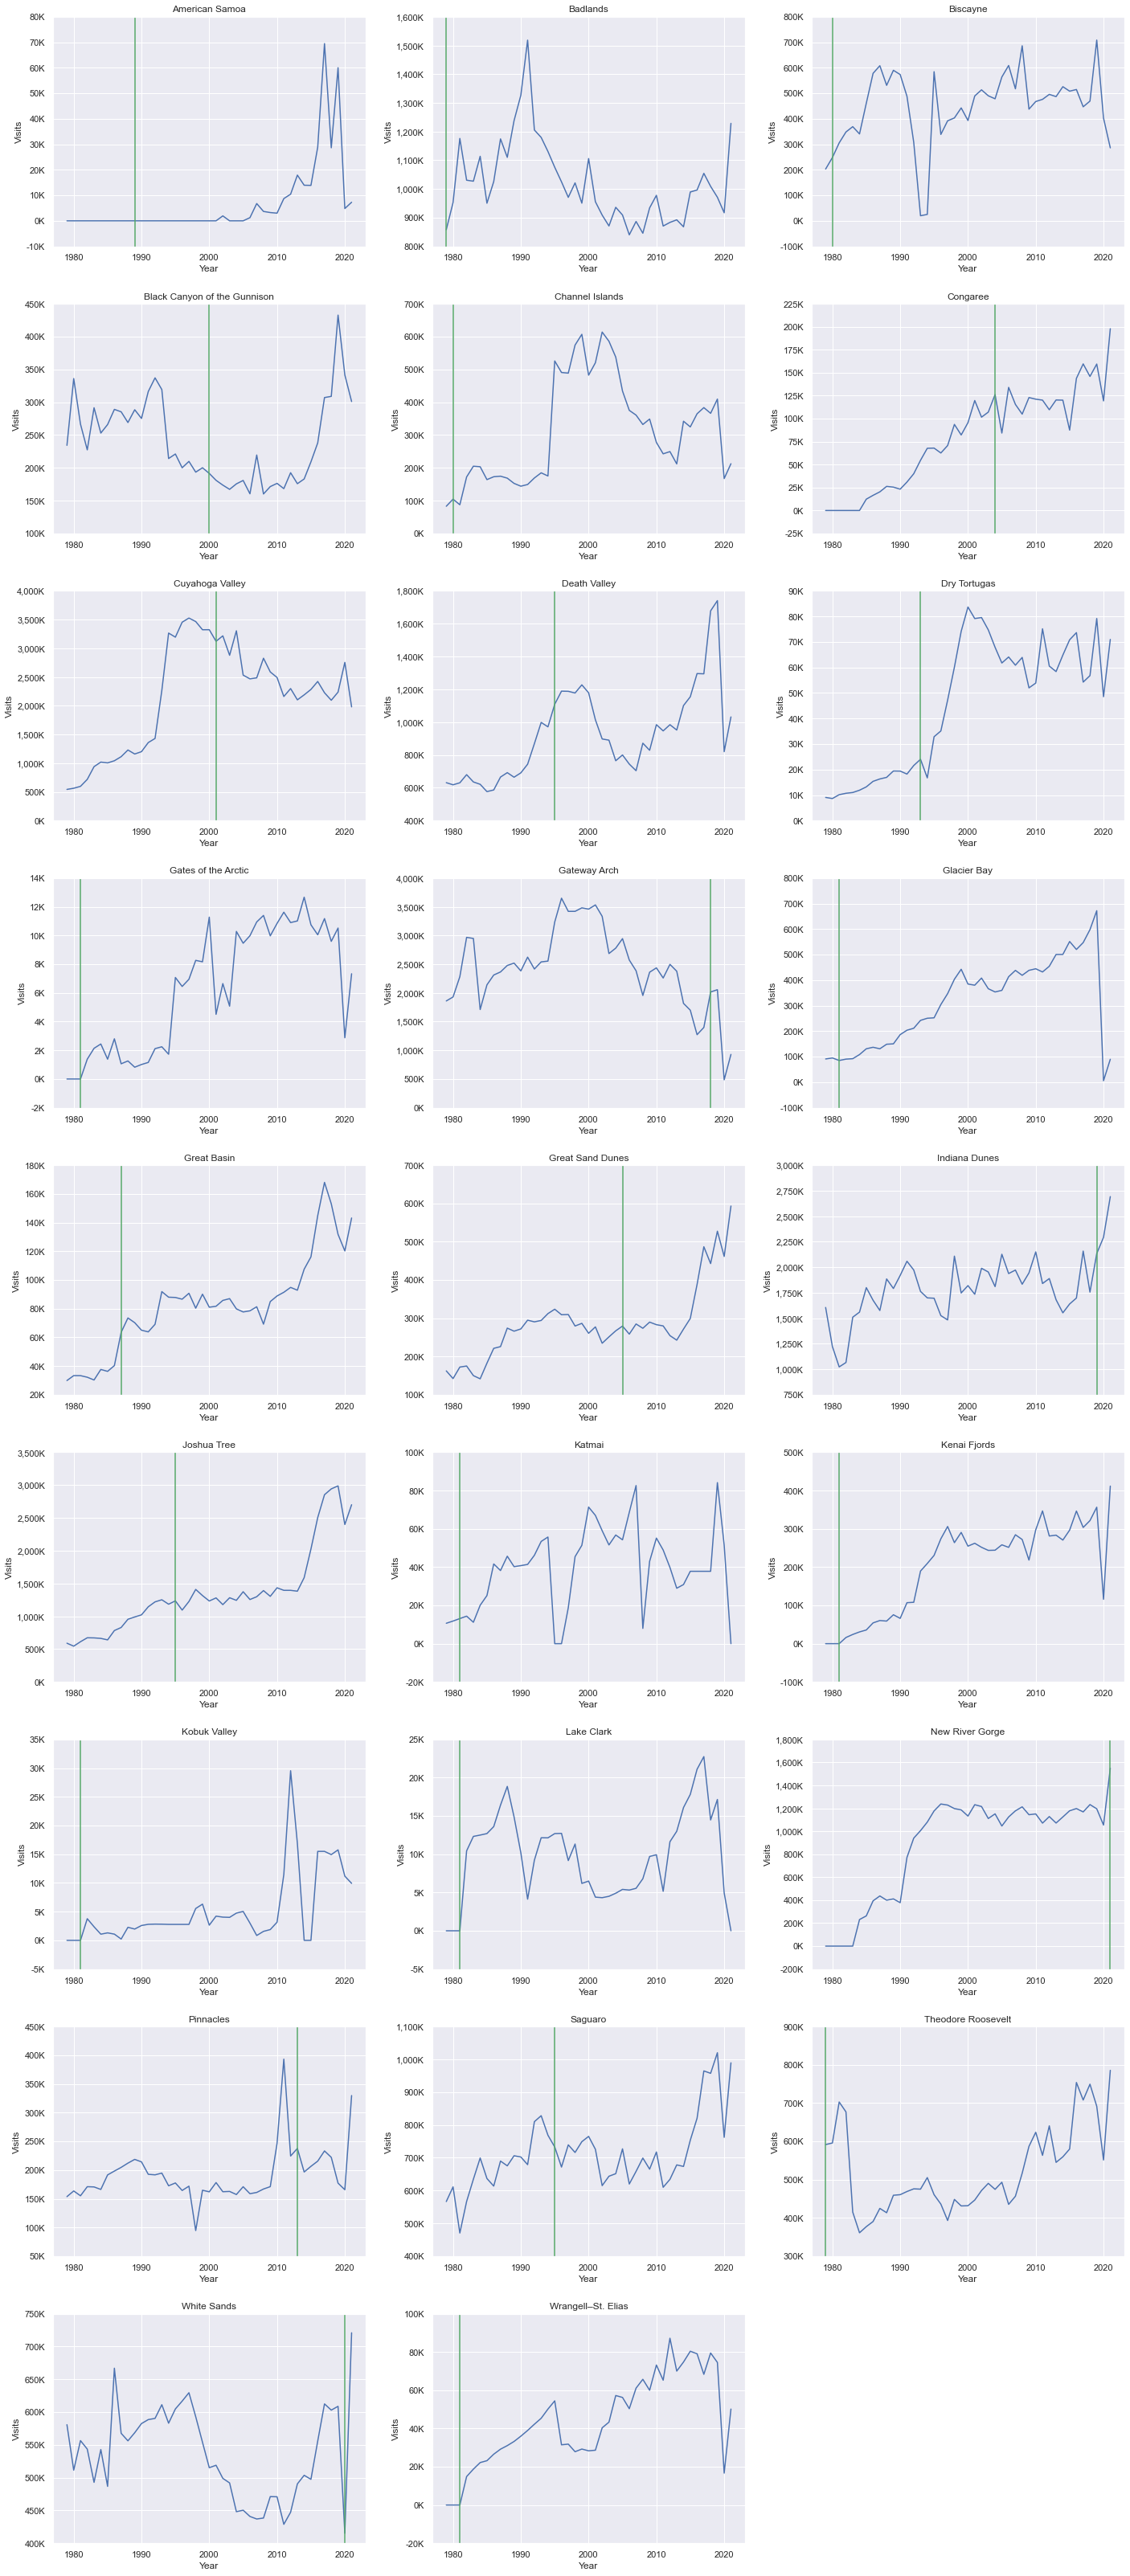

In [461]:
num_parks = park_data_filtered_df.shape[0]
num_cols = 3
num_rows = int(num_parks / num_cols) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,num_rows * 5), tight_layout=dict(pad=2.0))

# Plot each park's annual visit counts.
# Place a gree vertical line on the First Year the park was a National Park
for i, (index, row) in enumerate(park_data_filtered_df.iterrows()):
    g_row, g_column = divmod(i, num_cols)
    current_ax = axes[g_row][g_column]
    g = sns.lineplot(data=dfm[dfm['Name'] == row['Name']], x='Year', y='Visits', ax = current_ax)
    g.set_title(row['Name'])
    ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
    g.set_yticks(g.get_yticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
    g.set_yticklabels(ylabels)
    current_ax.axvline(x=row['First Year'], color='g')

# Turn off remaining axes
for i in range(num_parks, num_rows*num_cols):
    g_row, g_column = divmod(i, num_cols)
    current_ax = axes[g_row][g_column]
    current_ax.axis('off')

#### Trim Scope and Visualize Percentage Increases
There doesn't seem to be an obvious correlation between National Park designation and an increase in annual visits.  
A few charts hint at an increase, but there isn't a clear pattern.  
In addition, we have some data issues.  
 - COVID resulted in a steep decline in visitors in 2020, so parks established around 2019 cannot be measured.
 - In addition, some parks don't have enough "pre-establishment" counts to determine a "post-establishment" increase.

We will trim the dataset further to only include parks with a least 3 years of data prior to their establishment as a park AND were established at least 3 years prior to COVID.  
Then we will examine visit increase as YoY increase percentages rather than raw visit numbers.


In [462]:
# The first year of the park must be 2017 or earlier in order to have at least 3 years of data prior to COVID.
pre_covid_test = park_data_filtered_df['First Year'] <= 2017
park_data_filtered_df = park_data_filtered_df[pre_covid_test]

# This also means we can also remove 2020 and 2021 data since we are excluding COVID years from the analysis.
park_data_filtered_df.drop(columns=[2020, 2021], inplace=True)

# The first year of non-zero visists must be 3 years before the parks "First Year"
# Create a column that contains the first year with visit counts.  This one needs some explaining...
    # park_data_filtered_df.columns[...] will return the name of the column we want.  We are passing in the target index.
    # We find the target_index by first slicing the df to only the Years columns that have visit counts (.loc[:,1979:]).
    # And from that slice, we get an array of indexes indicating which columns are non-zero for each row of the dataframe (lambda x: x.to_numpy().nonzero()).
    # From each array, we calculate the minimum, which is the first column with non-zero values ([0][0].min()).
    # We add 6 to that minimum since our original slice excluded the first 6 columns of the main dataframe (+ 6).
    # After adding 6, we have the target_index that we can pass to the original columns function to retrieve the first non-zero Year.
park_data_filtered_df['First Count'] = park_data_filtered_df.columns[park_data_filtered_df.loc[:,1979:].apply(lambda x: x.to_numpy().nonzero()[0][0].min() + 6, axis=1)]

data_three_years_back_test = park_data_filtered_df['First Count'] <= (park_data_filtered_df['First Year'] - 3)
park_data_filtered_df = park_data_filtered_df[data_three_years_back_test]

print(park_data_filtered_df.shape)

# Re-do the melt
year_columns = [base_year + i for i in range(2019 - base_year + 1)]
dfm = park_data_filtered_df.melt(id_vars=['Name', 'First Year'], value_vars=year_columns, var_name='Year', value_name='Visits').sort_values(by=['Name','Year'])
dfm.head()

(10, 49)


,Name,First Year,Year,Visits
0,Black Canyon of the Gunnison,2000,1979,234286
10,Black Canyon of the Gunnison,2000,1980,336119
20,Black Canyon of the Gunnison,2000,1981,266604
30,Black Canyon of the Gunnison,2000,1982,227428
40,Black Canyon of the Gunnison,2000,1983,291618


We are down to 10 parks to analyze.  Let's re-create the grpahs for each chart showing the annual visits from 1979 to 2019.
A barplot might be a more accurate way to visualize the data, since our values are annual, so we will switch to that chart type to review.
A green bar will be used to indicate the year the park became a National Park.

<AxesSubplot:xlabel='Year', ylabel='Visits'>

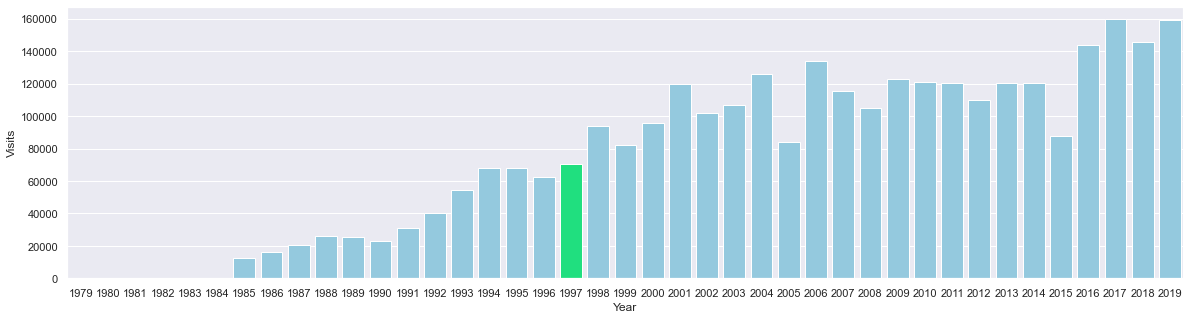

In [463]:
sns.set(rc = {'figure.figsize':(20,5)})
colors = ["skyblue" if x!=1997 else 'springgreen' for x in dfm['Year']]
sns.barplot(data=dfm[dfm['Name'] == 'Congaree'], x='Year', y='Visits', palette=colors)


TypeError: 'AxesSubplot' object is not subscriptable

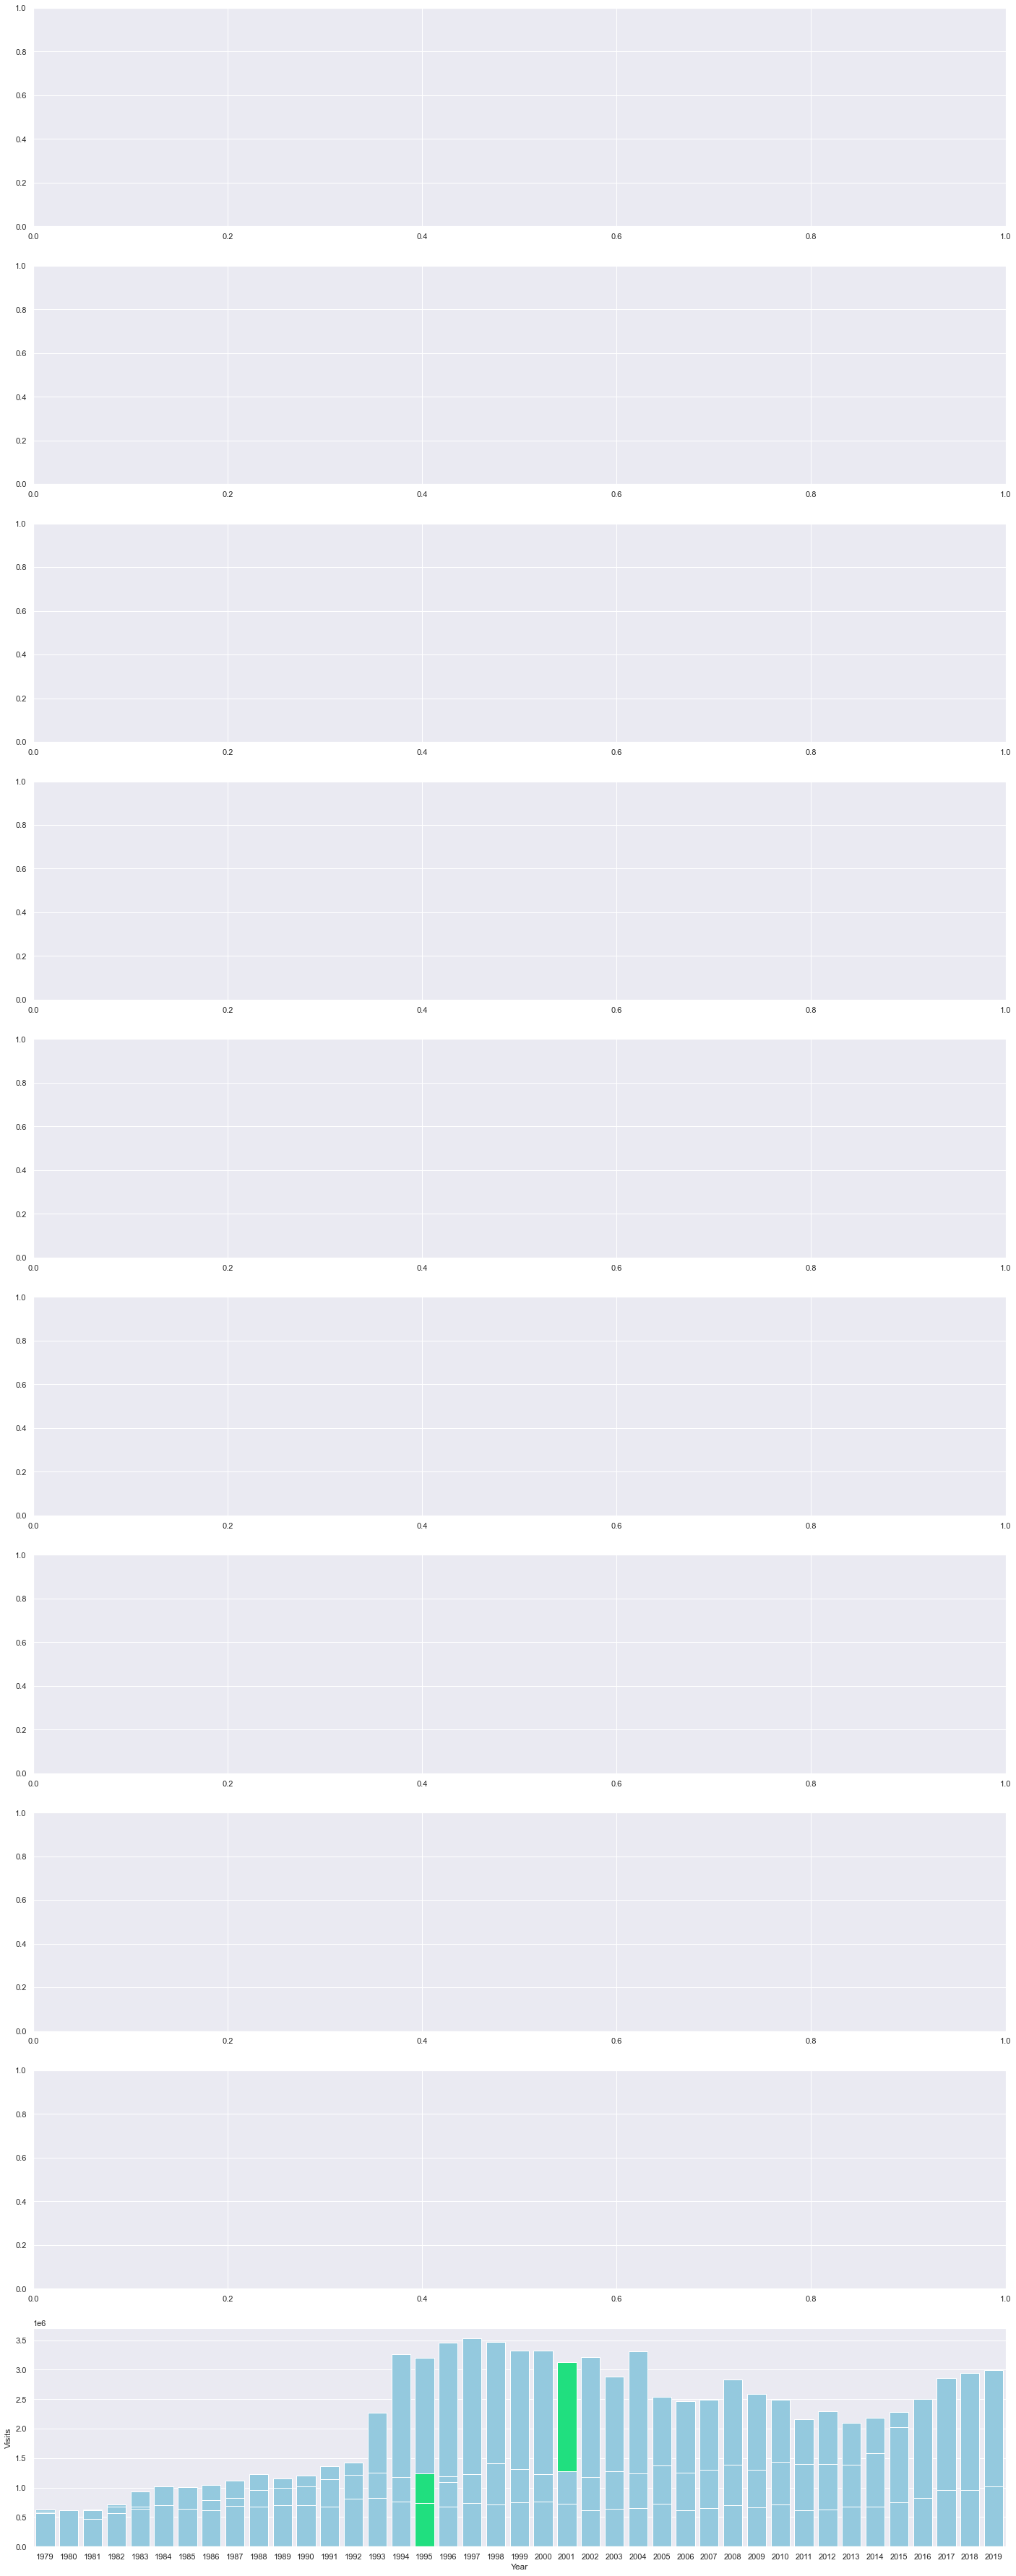

In [464]:
num_parks = park_data_filtered_df.shape[0]

fig, axes = plt.subplots(nrows=num_parks, figsize=(20, num_parks * 5), tight_layout=dict(pad=2.0))

# Plot each park's annual visit counts.
# Place a gree vertical line on the First Year the park was a National Park
for i, (index, row) in enumerate(park_data_filtered_df.iterrows()):
    current_ax = axes[i]
    colors = ["skyblue" if x!=row['First Year'] else 'springgreen' for x in dfm['Year']]
    sns.barplot(data=dfm[dfm['Name'] == row['Name']], x='Year', y='Visits', palette=colors)
    # g = sns.lineplot(data=dfm[dfm['Name'] == row['Name']], x='Year', y='Visits', ax = current_ax)
    g.set_title(row['Name'])
    ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
    g.set_yticks(g.get_yticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
    g.set_yticklabels(ylabels)
    # current_ax.axvline(x=row['First Year'], color='g')

# Turn off remaining axes
for i in range(num_parks, num_rows*num_cols):
    g_row, g_column = divmod(i, num_cols)
    current_ax = axes[g_row][g_column]
    current_ax.axis('off')